In [279]:
import itertools

import numpy
import pandas as pd
import random
import sklearn
from sklearn.model_selection import train_test_split
import datetime
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb

# import graphviz

In [280]:
"""
Our first goal is going to be data cleaning and munging. We want to take care of all null values
first.
"""

df_training = pd.read_csv('police_killings_train.csv')
df_test = pd.read_csv('police_killings_test.csv')
df_race_city = pd.read_csv('share_race_by_city.csv')
df_income = pd.read_csv('income.csv', encoding="ANSI")
df_poverty = pd.read_csv('poverty.csv', encoding="ANSI")
df_education = pd.read_csv('education.csv', encoding="ANSI")

df_test.info()
df_training

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 507 entries, 0 to 506
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       507 non-null    int64  
 1   name                     507 non-null    object 
 2   date                     507 non-null    object 
 3   manner_of_death          507 non-null    object 
 4   armed                    504 non-null    object 
 5   age                      467 non-null    float64
 6   gender                   507 non-null    object 
 7   race                     403 non-null    object 
 8   city                     507 non-null    object 
 9   state                    507 non-null    object 
 10  signs_of_mental_illness  507 non-null    bool   
 11  threat_level             507 non-null    object 
 12  flee                     469 non-null    object 
 13  body_camera              507 non-null    bool   
dtypes: bool(2), float64(1), in

,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera
0,3,Tim Elliot,02/01/15,shot,gun,53.0,M,A,Shelton,WA,True,attack,Not fleeing,False
1,4,Lewis Lee Lembke,02/01/15,shot,gun,47.0,M,W,Aloha,OR,False,attack,Not fleeing,False
2,5,John Paul Quintero,03/01/15,shot and Tasered,unarmed,23.0,M,H,Wichita,KS,False,other,Not fleeing,False
3,8,Matthew Hoffman,04/01/15,shot,toy weapon,32.0,M,W,San Francisco,CA,True,attack,Not fleeing,False
4,9,Michael Rodriguez,04/01/15,shot,nail gun,39.0,M,H,Evans,CO,False,attack,Not fleeing,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023,2256,Jeremy Lopez-Robledo,24/01/17,shot,knife,29.0,M,H,Las Cruces,NM,True,attack,Foot,True
2024,2257,Jonathan David Sper,24/01/17,shot,unarmed,30.0,M,W,Algoma Township,MI,True,attack,Not fleeing,False
2025,2258,Jose Efrain Rodriguez,24/01/17,shot and Tasered,gun,18.0,M,H,Lancaster City,PA,False,attack,Not fleeing,False
2026,2259,Ramon Milanez,24/01/17,shot,gun,32.0,M,H,Kuna,ID,False,attack,Car,False


In [281]:
"""
We will combine the training and tesing dataset to make cleaning easier and more accurate
"""

df_total = df_training.append(df_test, ignore_index=True)
df_total

,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera
0,3,Tim Elliot,02/01/15,shot,gun,53.0,M,A,Shelton,WA,True,attack,Not fleeing,False
1,4,Lewis Lee Lembke,02/01/15,shot,gun,47.0,M,W,Aloha,OR,False,attack,Not fleeing,False
2,5,John Paul Quintero,03/01/15,shot and Tasered,unarmed,23.0,M,H,Wichita,KS,False,other,Not fleeing,False
3,8,Matthew Hoffman,04/01/15,shot,toy weapon,32.0,M,W,San Francisco,CA,True,attack,Not fleeing,False
4,9,Michael Rodriguez,04/01/15,shot,nail gun,39.0,M,H,Evans,CO,False,attack,Not fleeing,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2530,2822,Rodney E. Jacobs,28/07/17,shot,gun,31.0,M,NaN,Kansas City,MO,False,attack,Not fleeing,False
2531,2813,TK TK,28/07/17,shot,vehicle,NaN,M,NaN,Albuquerque,NM,False,attack,Car,False
2532,2818,Dennis W. Robinson,29/07/17,shot,gun,48.0,M,NaN,Melba,ID,False,attack,Car,False
2533,2817,Isaiah Tucker,31/07/17,shot,vehicle,28.0,M,B,Oshkosh,WI,False,attack,Car,True


In [282]:
print(df_income.info())
df_race_city.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29322 entries, 0 to 29321
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Geographic Area  29322 non-null  object
 1   City             29322 non-null  object
 2   Median Income    29271 non-null  object
dtypes: object(3)
memory usage: 687.4+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29268 entries, 0 to 29267
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Geographic area        29268 non-null  object
 1   City                   29268 non-null  object
 2   share_white            29268 non-null  object
 3   share_black            29268 non-null  object
 4   share_native_american  29268 non-null  object
 5   share_asian            29268 non-null  object
 6   share_hispanic         29268 non-null  object
dtypes: object(7)
memory usage: 1.6+ MB


In [283]:
"""
There are many missing fields across all the supporting/optional datasets, in order to resolve this we need
to merge these datasets and then make the necessary imputation.
1. All data sets have a state and city type columns, merge those columns such that they can all have a column
to for indexing.
2. Get the list of cities within the mandatory dataset, we need to confirm that the supporting dataset
has these cities and if not then we need to impute.
"""
#make a list of unique cities, and include the state so we don't deal with same city names of different states
df_total['city'] = df_total[['state', 'city']].apply("-".join,axis=1)
df_race_city['city'] = df_race_city[['Geographic area', 'City']].apply("-".join,axis=1)
df_income['city'] = df_income[['Geographic Area', 'City']].apply("-".join,axis=1)
df_poverty['city'] = df_poverty[['Geographic Area', 'City']].apply("-".join,axis=1)
df_education['city'] = df_education[['Geographic Area', 'City']].apply("-".join,axis=1)
df_income = df_income.drop(['Geographic Area', 'City'], axis=1)
df_poverty = df_poverty.drop(columns=['Geographic Area', 'City'])
df_education = df_education.drop(columns=['Geographic Area', 'City'])
cities = df_total['city'].tolist()
cities =list(set(cities))
print(len(cities))
cities

1534


['CA-Carson',
 'NM-Santa Fe',
 'NV-Silver Springs',
 'CA-Hawaiian Gardens',
 'GA-Atlanta',
 'IL-Hurst',
 'IL-Arcola',
 'MI-Saginaw',
 'AZ-Cottonwood',
 'LA-Marksville',
 'AR-Farmington',
 'CO-Pueblo',
 'NM-Rowe',
 'OH-Rome',
 'AL-Meridianville',
 'MA-Weymouth',
 'TX-Winnie',
 'GA-Cobb County',
 'CO-Trinidad',
 'IL-Shawnee National Forest',
 'GA-Newnan',
 'IL-Marion',
 'VA-Richmond',
 'CA-Barona Indian Reservation',
 'GA-Cedartown',
 'CA-Moreno Valley',
 'NM-Eldorado',
 'PA-South Greensburg',
 'MS-Ruth',
 'TN-Morristown',
 'MN-Plymouth',
 'CA-West Covina',
 'CT-Fairfield',
 'UT-Milcreek',
 'NC-Raleigh',
 'NC-Pleasant Hill',
 'CA-Lincoln',
 'LA-Gretna',
 'CA-Fontana',
 'CA-La Quinta',
 'KS-Udall',
 'CT-Thomaston',
 'CA-Tustin',
 'UT-Provo',
 'CA-Pleasanton',
 'PA-Somerset',
 'CA-San Mateo',
 'VA-Culpeper',
 'ID-Rexburg',
 'AR-Fayetteville',
 'GA-Albany',
 'FL-Plantation',
 'CA-Pomona',
 'FL-Fort Lauderdale',
 'MN-St. Cloud',
 'SC-Cayce',
 'WA-East Wenatchee',
 'WA-Thurston County',
 'GA-

In [284]:
"""
First lets merge each of the supporting datasets into df_temp.
We noticed that the missing values aren't consistent in the supporting datasets. So we need to change all types of
missing values to NAN such that we can impute using fillna().
"""
print(df_race_city.info())
df_temp = pd.merge(df_race_city, df_income, on='city', how='outer', sort=True)
df_temp = pd.merge(df_temp, df_poverty, on='city', how='outer', sort=True)
df_temp = pd.merge(df_temp, df_education, on='city', how='outer', sort=True)
columns_supp = df_temp.columns.values.tolist()
for i in columns_supp:
    df_temp[i] = df_temp[i].replace('-', '(X)')
    df_temp[i] = df_temp[i].replace('(X)', numpy.NAN)
print(df_temp.info())
df_temp

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29268 entries, 0 to 29267
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Geographic area        29268 non-null  object
 1   City                   29268 non-null  object
 2   share_white            29268 non-null  object
 3   share_black            29268 non-null  object
 4   share_native_american  29268 non-null  object
 5   share_asian            29268 non-null  object
 6   share_hispanic         29268 non-null  object
 7   city                   29268 non-null  object
dtypes: object(8)
memory usage: 1.8+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 29477 entries, 0 to 29476
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Geographic area        29268 non-null  object
 1   City                   29268 non-null  object
 2   share_white        

,Geographic area,City,share_white,share_black,share_native_american,share_asian,share_hispanic,city,Median Income,poverty_rate,percent_completed_hs
0,AK,Adak city,19.6,4,5.5,52.5,8.9,AK-Adak city,78500,39.3,93.4
1,AK,Akhiok city,8.5,1.4,50.7,1.4,11.3,AK-Akhiok city,26250,40.5,62.5
2,AK,Akiachak CDP,3.5,0.2,95.1,0.2,0.2,AK-Akiachak CDP,38750,26.1,76.7
3,AK,Akiak city,5.2,0,92.8,0,0.3,AK-Akiak city,42000,31.3,81.3
4,AK,Akutan city,23.3,17.9,5.5,43.3,20.8,AK-Akutan city,24750,16.1,73
...,...,...,...,...,...,...,...,...,...,...,...
29472,WY,Woods Landing-Jelm CDP,95.9,0,0,2.1,0,WY-Woods Landing-Jelm CDP,NaN,18.6,100
29473,WY,Worland city,89.9,0.3,1.3,0.6,16.6,WY-Worland city,41523,15.3,85.6
29474,WY,Wright town,94.5,0.1,1.4,0.2,6.2,WY-Wright town,77114,5.9,89.2
29475,WY,Y-O Ranch CDP,92.8,1.5,2.6,0,11.8,WY-Y-O Ranch CDP,NaN,0,100


In [285]:
"""
Let's try cleaning the the race of city dataset now viewing the missing datapoints which are denoted at (X).
"""
# df_temp['city'] = df_temp[['Geographic area', 'City']].apply("-".join,axis=1)
# list_race_df = df_temp.values.tolist()
# j = 0
# list_bad_cities = []
# for i in list_race_df:
#     #we can see it is only null when all races are missing
#     if(i.count('(X)') > 0):
#         j+=1
#         list_bad_cities.append(i[1])
#         print(i.count('(X)') )
# print("total cities with bad points = ", j)


"\nLet's try cleaning the the race of city dataset now viewing the missing datapoints which are denoted at (X).\n"

In [286]:
"""With only 20/29260 holding a row of null values, we shall drop these cities"""
# tempDf_race = df_temp[df_race_city.share_white != '(X)'].copy()
# print(tempDf_race.info())
# df_race_city.info()

'With only 20/29260 holding a row of null values, we shall drop these cities'

In [287]:
"""
We want to make sure all the cities that are in our mandatory dataset is accounted for in the supporting.
We shall add those cities if they aren't and impute them as nulls
"""
#we can check that all the cities in the total data set is still in the race_city dataset
cities2 = df_temp['city'].tolist()
cities2 =list(set(cities2))
j = 0
missing = 0
cities.sort()
cities2.sort()
rep_val = 0
for i in cities:
    # print(i in cities2)
    # print(i)
    # print(cities2.index(i[0::1]))
    if(i in cities2):
        j+=1
    elif(any(i in string for string in cities2)):
        if len(df_temp[df_temp['city'].str.contains(i) ]) == 1 and sum(i in string for string in cities) == 1:
            print(i)
            df_temp['city'].loc[df_temp['city'].str.contains(i)] = i
            rep_val+=1

        else:
            newDF = {}
            #print(i)
            newDF['Geographic area'] = i[0:2]
            newDF['City'] = i[3:]
            newDF['city'] = i
            ind = 0
            df_temp = df_temp.append(newDF, ignore_index=True)
            cities2 = df_temp['city'].tolist()
            cities2 =list(set(cities2))
            missing+=1

    else:
        newDF = {}
        #print(i)
        newDF['Geographic area'] = i[0:2]
        newDF['City'] = i[3:]
        newDF['city'] = i
        ind = 0
        df_temp = df_temp.append(newDF, ignore_index=True)
        cities2 = df_temp['city'].tolist()
        cities2 =list(set(cities2))
        missing+=1


print(j)
print("Replaced cities ", rep_val)
print(" Was Missing ", missing)
df_temp.drop_duplicates(subset='city', inplace=True)
df_temp.reset_index(inplace=True)
df_temp

AK-Anchorage
AK-Barrow
AK-Big Lake
AK-Fairbanks
AK-Houston
AK-Wasilla
AL-Abbeville
AL-Arab
AL-Ashville
AL-Bay Minette
AL-Birmingham
AL-Clanton
AL-Dadeville
AL-Deer Park
AL-Eufaula
AL-Gadsden
AL-Homewood
AL-Hoover
AL-Huntsville
AL-Meridianville
AL-Millbrook
AL-Mobile
AL-Monroeville
AL-Montgomery
AL-Muscle Shoals
AL-Opelika
AL-Opp
AL-Oxford
AL-Phenix City
AL-Piedmont
AL-Rainbow City
AL-Saraland
AL-Selma
AL-Sylacauga
AL-Tuscaloosa
AL-Tuscumbia
AL-Westover
AR-Austin
AR-Bull Shoals
AR-Cabot
AR-Dover
AR-England
AR-Farmington
AR-Fayetteville
AR-Jonesboro
AR-Little Rock
AR-Manila
AR-Marion
AR-Mena
AR-Mountain Pine
AR-Perryville
AR-Sheridan
AR-Springdale
AR-Strong
AR-West Memphis
AZ-Apache Junction
AZ-Avondale
AZ-Bisbee
AZ-Buckeye
AZ-Bullhead City
AZ-Casa Grande
AZ-Chandler
AZ-Eagar
AZ-Flagstaff
AZ-Florence
AZ-Gilbert
AZ-Glendale
AZ-Golden Shores
AZ-Golden Valley
AZ-Kearny
AZ-Kingman
AZ-Lake Havasu City
AZ-Marana
AZ-Morenci
AZ-Phoenix
AZ-San Manuel
AZ-Scottsdale
AZ-Show Low
AZ-Somerton
AZ-Surpr

,index,Geographic area,City,share_white,share_black,share_native_american,share_asian,share_hispanic,city,Median Income,poverty_rate,percent_completed_hs
0,0,AK,Adak city,19.6,4,5.5,52.5,8.9,AK-Adak city,78500,39.3,93.4
1,1,AK,Akhiok city,8.5,1.4,50.7,1.4,11.3,AK-Akhiok city,26250,40.5,62.5
2,2,AK,Akiachak CDP,3.5,0.2,95.1,0.2,0.2,AK-Akiachak CDP,38750,26.1,76.7
3,3,AK,Akiak city,5.2,0,92.8,0,0.3,AK-Akiak city,42000,31.3,81.3
4,4,AK,Akutan city,23.3,17.9,5.5,43.3,20.8,AK-Akutan city,24750,16.1,73
...,...,...,...,...,...,...,...,...,...,...,...,...
29816,29816,WV,Braxton County,NaN,NaN,NaN,NaN,NaN,WV-Braxton County,NaN,NaN,NaN
29817,29817,WV,Gerrardstown,NaN,NaN,NaN,NaN,NaN,WV-Gerrardstown,NaN,NaN,NaN
29818,29818,WV,Hensley,NaN,NaN,NaN,NaN,NaN,WV-Hensley,NaN,NaN,NaN
29819,29819,WV,Petroleum,NaN,NaN,NaN,NaN,NaN,WV-Petroleum,NaN,NaN,NaN


In [288]:
cities2 = df_temp['city'].tolist()
cities2 =list(set(cities2))
j = 0
for i in cities:
    # print(i in cities2)
    # print(i)
    # print(cities2.index(i[0::1]))
    if(i in  cities2):
        j+=1
#confirming that all the cities were placed in
print(j)

1534


In [289]:
df_temp.sort_values(by=['city'], inplace=True)
df_temp

,index,Geographic area,City,share_white,share_black,share_native_american,share_asian,share_hispanic,city,Median Income,poverty_rate,percent_completed_hs
0,0,AK,Adak city,19.6,4,5.5,52.5,8.9,AK-Adak city,78500,39.3,93.4
1,1,AK,Akhiok city,8.5,1.4,50.7,1.4,11.3,AK-Akhiok city,26250,40.5,62.5
2,2,AK,Akiachak CDP,3.5,0.2,95.1,0.2,0.2,AK-Akiachak CDP,38750,26.1,76.7
3,3,AK,Akiak city,5.2,0,92.8,0,0.3,AK-Akiak city,42000,31.3,81.3
4,4,AK,Akutan city,23.3,17.9,5.5,43.3,20.8,AK-Akutan city,24750,16.1,73
...,...,...,...,...,...,...,...,...,...,...,...,...
29472,29472,WY,Woods Landing-Jelm CDP,95.9,0,0,2.1,0,WY-Woods Landing-Jelm CDP,NaN,18.6,100
29473,29473,WY,Worland city,89.9,0.3,1.3,0.6,16.6,WY-Worland city,41523,15.3,85.6
29474,29474,WY,Wright town,94.5,0.1,1.4,0.2,6.2,WY-Wright town,77114,5.9,89.2
29475,29475,WY,Y-O Ranch CDP,92.8,1.5,2.6,0,11.8,WY-Y-O Ranch CDP,NaN,0,100


In [290]:
"""
We want to impute the city and our state/Geographic area such that we have a full comprehensive list of both
separately after the merge.
Then we want to get a list of race names within the df_race_city.
"""

df_temp['Geographic area'] = [i[0:2] for i in df_temp['city']]
df_temp['City'] = [i[3:] for i in df_temp['city']]
print(df_temp)
list_states = df_temp['Geographic area'].values.tolist()
list_states = list(set(list_states))
#we expect to see 51 including DC as a state
print(len(list_states))
columns_race = df_temp.columns.values.tolist()
s = 'share'
columns_race = [string for string in columns_race if(s in string)]
columns_race

       index Geographic area                    City share_white share_black  \
0          0              AK               Adak city        19.6           4   
1          1              AK             Akhiok city         8.5         1.4   
2          2              AK            Akiachak CDP         3.5         0.2   
3          3              AK              Akiak city         5.2           0   
4          4              AK             Akutan city        23.3        17.9   
...      ...             ...                     ...         ...         ...   
29472  29472              WY  Woods Landing-Jelm CDP        95.9           0   
29473  29473              WY            Worland city        89.9         0.3   
29474  29474              WY             Wright town        94.5         0.1   
29475  29475              WY           Y-O Ranch CDP        92.8         1.5   
29476  29476              WY              Yoder town        97.4           0   

      share_native_american share_asian

['share_white',
 'share_black',
 'share_native_american',
 'share_asian',
 'share_hispanic']

In [291]:
"""
Now we can impute the porportion of missing cities based on the state's porportions
"""
for state in list_states:
    j=0
    list_total_races = []
    state_df = df_temp.loc[df_temp['Geographic area'] == state]
    for i in columns_race:
        state_df[i] = state_df[i].astype(float)
        list_total_races.append(state_df[i].sum())
        print(list_total_races[j])
        j+=1
    sum_all_races = sum(list_total_races)
    porportional_share = [i/sum_all_races for i in list_total_races]
    #print(porportional_share, " sum= ", sum(porportional_share))
    j=0
    for i in columns_race:
        state_df[i] = state_df[i].fillna(porportional_share[j])
        j+=1
    df_temp.loc[df_temp['Geographic area'] == state] = state_df
print(df_temp.info())
df_temp



144370.7
10277.8
1151.6999999999998
1773.8000000000002
68809.79999999999
18659.5
80.69999999999999
625.2
78.7
1215.6
5038.799999999999
161.7
58.60000000000001
3873.9
1564.1
20161.6
67.0
573.1
110.69999999999999
2427.8
30833.699999999997
82.7
4332.900000000001
116.4
800.1
37009.799999999996
143.3
2137.3
117.69999999999999
731.0
164498.7
5768.7
285.0
1744.6
4820.2
12534.900000000001
107.39999999999999
71.4
135.2
172.0
38158.3
3132.9
135.8
273.4
1225.3
33078.9
113.1
4690.400000000001
124.0
794.4000000000001
38109.200000000004
1169.0
80.30000000000001
136.8
362.59999999999997
24480.399999999998
12969.599999999999
182.8
292.3
1767.8
44086.9
9757.9
202.3
2168.3999999999996
3636.4
16068.800000000001
199.70000000000002
16144.4
488.7
756.5
83171.0
906.7
3047.0
929.3
2857.4
72378.70000000001
12301.199999999999
419.0
1487.4
15206.8
12313.100000000002
713.8999999999999
93.9
427.5
1140.5
30657.300000000003
14556.8
452.8
372.0
1407.9
41909.200000000004
13480.3
381.09999999999997
277.29999999999995
1

,index,Geographic area,City,share_white,share_black,share_native_american,share_asian,share_hispanic,city,Median Income,poverty_rate,percent_completed_hs
0,0,AK,Adak city,19.6,4.0,5.5,52.5,8.9,AK-Adak city,78500,39.3,93.4
1,1,AK,Akhiok city,8.5,1.4,50.7,1.4,11.3,AK-Akhiok city,26250,40.5,62.5
2,2,AK,Akiachak CDP,3.5,0.2,95.1,0.2,0.2,AK-Akiachak CDP,38750,26.1,76.7
3,3,AK,Akiak city,5.2,0.0,92.8,0.0,0.3,AK-Akiak city,42000,31.3,81.3
4,4,AK,Akutan city,23.3,17.9,5.5,43.3,20.8,AK-Akutan city,24750,16.1,73
...,...,...,...,...,...,...,...,...,...,...,...,...
29472,29472,WY,Woods Landing-Jelm CDP,95.9,0.0,0.0,2.1,0.0,WY-Woods Landing-Jelm CDP,NaN,18.6,100
29473,29473,WY,Worland city,89.9,0.3,1.3,0.6,16.6,WY-Worland city,41523,15.3,85.6
29474,29474,WY,Wright town,94.5,0.1,1.4,0.2,6.2,WY-Wright town,77114,5.9,89.2
29475,29475,WY,Y-O Ranch CDP,92.8,1.5,2.6,0.0,11.8,WY-Y-O Ranch CDP,NaN,0,100


In [292]:
df_temp['Median Income'] = pd.to_numeric(df_temp['Median Income'], errors='coerce')
df_temp['poverty_rate'] = pd.to_numeric(df_temp['poverty_rate'], errors='coerce')
df_temp['percent_completed_hs'] = pd.to_numeric(df_temp['percent_completed_hs'], errors='coerce')
for state in list_states:
    state_df = df_temp.loc[df_temp['Geographic area'] == state]
    state_df['Median Income'] = state_df['Median Income'].fillna(state_df['Median Income'].mean())
    state_df['poverty_rate'] = state_df['poverty_rate'].fillna(state_df['poverty_rate'].mean())
    state_df['percent_completed_hs'] =state_df['percent_completed_hs'].fillna(state_df['percent_completed_hs'].mean())
    df_temp.loc[df_temp['Geographic area'] == state] = state_df
print(df_temp.info())

df_temp

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29821 entries, 0 to 29476
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   index                  29821 non-null  int64  
 1   Geographic area        29821 non-null  object 
 2   City                   29821 non-null  object 
 3   share_white            29821 non-null  object 
 4   share_black            29821 non-null  object 
 5   share_native_american  29821 non-null  object 
 6   share_asian            29821 non-null  object 
 7   share_hispanic         29821 non-null  object 
 8   city                   29821 non-null  object 
 9   Median Income          29821 non-null  float64
 10  poverty_rate           29821 non-null  float64
 11  percent_completed_hs   29821 non-null  float64
dtypes: float64(3), int64(1), object(8)
memory usage: 3.0+ MB
None


,index,Geographic area,City,share_white,share_black,share_native_american,share_asian,share_hispanic,city,Median Income,poverty_rate,percent_completed_hs
0,0,AK,Adak city,19.6,4.0,5.5,52.5,8.9,AK-Adak city,78500.000000,39.3,93.4
1,1,AK,Akhiok city,8.5,1.4,50.7,1.4,11.3,AK-Akhiok city,26250.000000,40.5,62.5
2,2,AK,Akiachak CDP,3.5,0.2,95.1,0.2,0.2,AK-Akiachak CDP,38750.000000,26.1,76.7
3,3,AK,Akiak city,5.2,0.0,92.8,0.0,0.3,AK-Akiak city,42000.000000,31.3,81.3
4,4,AK,Akutan city,23.3,17.9,5.5,43.3,20.8,AK-Akutan city,24750.000000,16.1,73.0
...,...,...,...,...,...,...,...,...,...,...,...,...
29472,29472,WY,Woods Landing-Jelm CDP,95.9,0.0,0.0,2.1,0.0,WY-Woods Landing-Jelm CDP,60874.993464,18.6,100.0
29473,29473,WY,Worland city,89.9,0.3,1.3,0.6,16.6,WY-Worland city,41523.000000,15.3,85.6
29474,29474,WY,Wright town,94.5,0.1,1.4,0.2,6.2,WY-Wright town,77114.000000,5.9,89.2
29475,29475,WY,Y-O Ranch CDP,92.8,1.5,2.6,0.0,11.8,WY-Y-O Ranch CDP,60874.993464,0.0,100.0


In [293]:
#make a list of df fT-oubaor each city
list_df_cities = []
for i in cities:
    list_df_cities.append(df_total.loc[df_total['city'] == i])

In [294]:
#make a list of race
races = df_total['race'].tolist()
races =list(set(races))
races = races[1::]
races

['W', 'B', 'A', 'O', 'H', 'N']

In [295]:
mode_total = df_total['race'].mode(dropna=True).tolist()
print(mode_total)
for i in list_df_cities:
    mode = i['race'].mode(dropna=True)
    if(len(mode) == 0):
        i[['race']] = i[['race']].fillna(mode_total[0])
        if(i['race'].isnull().sum() != 0):
            print("null val")
    elif(isinstance(mode, type(i['race']))):
        mode.dropna()
        mode = mode.tolist()
        #if the mode has more than one value then take a random choice between the values
        i[['race']] = i[['race']].fillna(random.choice(tuple(mode)))



    df_total.loc[df_total['city'] ==  i.at[i.first_valid_index(),'city']] = i
df_total.info()

['W']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2535 entries, 0 to 2534
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       2535 non-null   int64  
 1   name                     2535 non-null   object 
 2   date                     2535 non-null   object 
 3   manner_of_death          2535 non-null   object 
 4   armed                    2526 non-null   object 
 5   age                      2458 non-null   float64
 6   gender                   2535 non-null   object 
 7   race                     2535 non-null   object 
 8   city                     2535 non-null   object 
 9   state                    2535 non-null   object 
 10  signs_of_mental_illness  2535 non-null   bool   
 11  threat_level             2535 non-null   object 
 12  flee                     2470 non-null   object 
 13  body_camera              2535 non-null   bool   
dtypes: bool(2), float6

In [296]:
 # removed all data with NaN in race Column...df_training[df_training['race'].isnull()]
df_total

,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera
0,3,Tim Elliot,02/01/15,shot,gun,53.0,M,A,WA-Shelton,WA,True,attack,Not fleeing,False
1,4,Lewis Lee Lembke,02/01/15,shot,gun,47.0,M,W,OR-Aloha,OR,False,attack,Not fleeing,False
2,5,John Paul Quintero,03/01/15,shot and Tasered,unarmed,23.0,M,H,KS-Wichita,KS,False,other,Not fleeing,False
3,8,Matthew Hoffman,04/01/15,shot,toy weapon,32.0,M,W,CA-San Francisco,CA,True,attack,Not fleeing,False
4,9,Michael Rodriguez,04/01/15,shot,nail gun,39.0,M,H,CO-Evans,CO,False,attack,Not fleeing,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2530,2822,Rodney E. Jacobs,28/07/17,shot,gun,31.0,M,B,MO-Kansas City,MO,False,attack,Not fleeing,False
2531,2813,TK TK,28/07/17,shot,vehicle,NaN,M,H,NM-Albuquerque,NM,False,attack,Car,False
2532,2818,Dennis W. Robinson,29/07/17,shot,gun,48.0,M,W,ID-Melba,ID,False,attack,Car,False
2533,2817,Isaiah Tucker,31/07/17,shot,vehicle,28.0,M,B,WI-Oshkosh,WI,False,attack,Car,True


In [297]:
"""
We noticed that some of the 'age' data is missing.
So we imputed the average age of the people in each city and imputed the average age for the missing ages based on their city.
1. We calculate the total mean age of our total data sample.
2. We group by city, then calculate the mean Age at each city.
3. For each NaN age, we impute the mean age of that city. If that city was not calcuated (meaning this data is the only one from that city), we will use the total mean age.
"""
age_fix = df_total[['id','age','city']].copy()
age_fix = age_fix[age_fix['age'].isnull()].copy()
# 1. Calculate Total Mean Age
total_mean_age = df_total['age'].mean()

# 2. Calculate Mean of Each City
city_mean_ages = df_total.groupby('city')['age'].mean()

#3. Impute Age by the city. If City data does not exist, use Total Mean Age.
for i in age_fix.index:
    city = age_fix['city'][i]
    if city in city_mean_ages and not np.isnan(city_mean_ages[city]):
        age_fix['age'][i] = city_mean_ages[city]
    else:
        age_fix['age'][i] = total_mean_age


# update total list
df_total.update(age_fix)

df_total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2535 entries, 0 to 2534
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       2535 non-null   float64
 1   name                     2535 non-null   object 
 2   date                     2535 non-null   object 
 3   manner_of_death          2535 non-null   object 
 4   armed                    2526 non-null   object 
 5   age                      2535 non-null   float64
 6   gender                   2535 non-null   object 
 7   race                     2535 non-null   object 
 8   city                     2535 non-null   object 
 9   state                    2535 non-null   object 
 10  signs_of_mental_illness  2535 non-null   bool   
 11  threat_level             2535 non-null   object 
 12  flee                     2470 non-null   object 
 13  body_camera              2535 non-null   bool   
dtypes: bool(2), float64(2), 

In [298]:
"""
We noticed there were missing values for 'armed' and 'flee'. For these, we imputed the most frequent data that appeared.
These are listed in the variables flee_mode and armed_mode
"""
flee_mode = df_total['flee'].agg(pd.Series.mode).values.tolist()[0]
armed_mode = df_total['armed'].agg(pd.Series.mode).values.tolist()[0]
df_total['flee'].fillna(flee_mode, inplace=True)
df_total['armed'].fillna(armed_mode, inplace=True)
df_total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2535 entries, 0 to 2534
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       2535 non-null   float64
 1   name                     2535 non-null   object 
 2   date                     2535 non-null   object 
 3   manner_of_death          2535 non-null   object 
 4   armed                    2535 non-null   object 
 5   age                      2535 non-null   float64
 6   gender                   2535 non-null   object 
 7   race                     2535 non-null   object 
 8   city                     2535 non-null   object 
 9   state                    2535 non-null   object 
 10  signs_of_mental_illness  2535 non-null   bool   
 11  threat_level             2535 non-null   object 
 12  flee                     2535 non-null   object 
 13  body_camera              2535 non-null   bool   
dtypes: bool(2), float64(2), 

In [299]:
"""
****GIVE EXPLANATION OF OUR ENTIRE PROCESS
########################### END OF DATA MUNGING##########################
"""


'\n****GIVE EXPLANATION OF OUR ENTIRE PROCESS\n########################### END OF DATA MUNGING##########################\n'

In [300]:
"""
Data Analysis
Exploratory Data Analysis (EDA 10 Points)
"""
df_total

,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera
0,3.0,Tim Elliot,02/01/15,shot,gun,53.000000,M,A,WA-Shelton,WA,True,attack,Not fleeing,False
1,4.0,Lewis Lee Lembke,02/01/15,shot,gun,47.000000,M,W,OR-Aloha,OR,False,attack,Not fleeing,False
2,5.0,John Paul Quintero,03/01/15,shot and Tasered,unarmed,23.000000,M,H,KS-Wichita,KS,False,other,Not fleeing,False
3,8.0,Matthew Hoffman,04/01/15,shot,toy weapon,32.000000,M,W,CA-San Francisco,CA,True,attack,Not fleeing,False
4,9.0,Michael Rodriguez,04/01/15,shot,nail gun,39.000000,M,H,CO-Evans,CO,False,attack,Not fleeing,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2530,2822.0,Rodney E. Jacobs,28/07/17,shot,gun,31.000000,M,B,MO-Kansas City,MO,False,attack,Not fleeing,False
2531,2813.0,TK TK,28/07/17,shot,vehicle,31.153846,M,H,NM-Albuquerque,NM,False,attack,Car,False
2532,2818.0,Dennis W. Robinson,29/07/17,shot,gun,48.000000,M,W,ID-Melba,ID,False,attack,Car,False
2533,2817.0,Isaiah Tucker,31/07/17,shot,vehicle,28.000000,M,B,WI-Oshkosh,WI,False,attack,Car,True


In [301]:
"""
Q: Which state has the most fatal police shootings? Which city is the most dangerous?
Create a collapsed dataframe of state. Create a collapsed data frame of Cities.
"""
# Make a copy of Total Data For City!
df_aux = df_total.copy()
df_aux.sort_values(by=['city'])

# The following dropped Columns are not used when data is collapsed as City
df_aux.drop(columns=['id', 'name', 'date', 'age', 'state'], inplace=True)
df_aux.set_index('city', inplace=True)
df_aux = df_aux.astype(str)
cols = df_aux.columns.tolist() # Move 'arms' to end of list
cols.append(cols.pop(cols.index('armed')))
df_aux = df_aux[cols]

# Get a list of 'df_aux' column names
aux_cols = df_aux.columns

# Get a list of the index cities (Sorted)
list_of_cities = df_aux.index.unique().tolist()
list_of_cities.sort()

# For each column, change the string such that  " 'COLUMN_NAME': + str + (s) " is the result for each string.
# This is important so that when we build/update our resulting Dataframe, it will have unique values per catagory.
for i in list_of_cities:
    for j in aux_cols:
        df_aux.at[i, j] =  j.upper() + ': ' + df_aux.at[i, j]

# Make the df_city_stats Columns
freq_list_cols = ['Total Cases']
for i in aux_cols:
    freq_list_cols = freq_list_cols + df_aux[i].unique().tolist()


# Create Dataframe to build up
df_city_stats = pd.DataFrame(index=list_of_cities, columns=freq_list_cols)
df_city_stats = df_city_stats.fillna(0)
for i in list_of_cities: # indexs
    temp = len(df_aux[df_aux.index == i])
    df_city_stats.loc[i]['Total Cases'] = temp
    for j in aux_cols:
        temp = df_aux[df_aux.index == i][j].value_counts()
        df_city_stats.loc[i].update(temp)

df_city_stats

,Total Cases,MANNER_OF_DEATH: shot,MANNER_OF_DEATH: shot and Tasered,GENDER: M,GENDER: F,RACE: A,RACE: W,RACE: H,RACE: B,RACE: O,...,ARMED: metal rake,ARMED: crowbar,ARMED: oar,ARMED: machete and gun,ARMED: tire iron,ARMED: air conditioner,ARMED: pole and knife,ARMED: baseball bat and bottle,ARMED: fireworks,ARMED: pen
AK-Anchorage,3,3,0,3,0,0,3,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AK-Barrow,1,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AK-Big Lake,1,1,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
AK-Fairbanks,5,4,1,5,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AK-Houston,1,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WY-Cheyenne,1,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
WY-Douglas,2,2,0,2,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
WY-Gillette,1,0,1,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
WY-Laramie,1,1,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [302]:
# Make a copy of Total Data For State!
df_aux = df_total.copy()
df_aux.sort_values(by=['state'])

# The following dropped Columns are not used when data is collapsed as City
df_aux.drop(columns=['id', 'name', 'date', 'age', 'city'], inplace=True)
df_aux.set_index('state', inplace=True)
df_aux = df_aux.astype(str)
cols = df_aux.columns.tolist() # Move 'arms' to end of list
cols.append(cols.pop(cols.index('armed')))
df_aux = df_aux[cols]

# Get a list of 'df_aux' column names
aux_cols = df_aux.columns

# Get a list of the index state (Sorted)
list_of_states = df_aux.index.unique().tolist()
list_of_states.sort()

# For each column, change the string such that  " 'COLUMN_NAME': + str + (s) " is the result for each string.
# This is important so that when we build/update our resulting Dataframe, it will have unique values per catagory.
for i in list_of_states:
    for j in aux_cols:
        df_aux.at[i, j] =  j.upper() + ': ' + df_aux.at[i, j]

# Make the df_city_stats Columns
freq_list_cols = ['Total Cases']
for i in aux_cols:
    freq_list_cols = freq_list_cols + df_aux[i].unique().tolist()


# Create Dataframe to build up
df_state_stats = pd.DataFrame(index=list_of_states, columns=freq_list_cols)
df_state_stats = df_state_stats.fillna(0)
for i in list_of_states: # indexs
    temp = len(df_aux[df_aux.index == i])
    df_state_stats.loc[i]['Total Cases'] = temp
    for j in aux_cols:
        temp = df_aux[df_aux.index == i][j].value_counts()
        df_state_stats.loc[i].update(temp)

df_state_stats

,Total Cases,MANNER_OF_DEATH: shot,MANNER_OF_DEATH: shot and Tasered,GENDER: M,GENDER: F,RACE: A,RACE: W,RACE: H,RACE: B,RACE: O,...,ARMED: metal rake,ARMED: crowbar,ARMED: oar,ARMED: machete and gun,ARMED: tire iron,ARMED: air conditioner,ARMED: pole and knife,ARMED: baseball bat and bottle,ARMED: fireworks,ARMED: pen
AK,15,14,1,14,1,0,7,0,1,0,...,0,0,0,0,0,0,0,0,0,0
AL,50,47,3,46,4,0,36,0,14,0,...,0,0,0,0,0,0,0,0,0,0
AR,26,25,1,26,0,0,19,0,7,0,...,0,0,0,0,0,0,0,0,0,0
AZ,118,112,6,108,10,0,67,38,5,0,...,0,0,0,0,0,0,0,0,0,0
CA,424,382,42,402,22,16,146,185,67,9,...,1,0,0,0,0,0,0,1,0,0
CO,74,71,3,72,2,2,39,23,9,0,...,0,0,0,0,0,0,0,0,0,0
CT,9,8,1,9,0,0,7,2,0,0,...,0,0,0,0,0,0,0,0,0,0
DC,11,11,0,9,2,0,1,0,10,0,...,0,0,0,0,0,0,0,0,0,0
DE,8,8,0,8,0,0,4,0,4,0,...,0,0,0,0,0,0,0,0,0,0
FL,154,143,11,148,6,1,83,18,50,2,...,0,0,1,0,0,0,0,0,0,0


In [303]:
"""
Now that we have the most accurate imputation using all of the support data. We want to hold a dataframe that contains cities that are also in the main data frame.
"""
j=0
df_support = pd.DataFrame(columns=columns_supp)
for i in cities:
    newDf= df_temp[df_temp['city'] == i].copy()
    if(len(newDf) > 1):
        print(i)
        print(newDf.info())
        print(newDf)
    df_support = df_support.append(newDf, ignore_index=True)
    df_support.drop_duplicates(inplace=True)
    j+=1
print(j)
print(df_support.info())
print(len(cities))
df_support

1534
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1534 entries, 0 to 1533
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Geographic area        1534 non-null   object 
 1   City                   1534 non-null   object 
 2   share_white            1534 non-null   object 
 3   share_black            1534 non-null   object 
 4   share_native_american  1534 non-null   object 
 5   share_asian            1534 non-null   object 
 6   share_hispanic         1534 non-null   object 
 7   city                   1534 non-null   object 
 8   Median Income          1534 non-null   object 
 9   poverty_rate           1534 non-null   object 
 10  percent_completed_hs   1534 non-null   object 
 11  index                  1534 non-null   float64
dtypes: float64(1), object(11)
memory usage: 155.8+ KB
None
1534


,Geographic area,City,share_white,share_black,share_native_american,share_asian,share_hispanic,city,Median Income,poverty_rate,percent_completed_hs,index
0,AK,Anchorage,66.0,5.6,7.9,8.1,7.6,AK-Anchorage,78326.0,8.2,93.0,14.0
1,AK,Barrow,16.9,1.0,61.2,9.1,3.1,AK-Barrow,76902.0,11.7,84.6,25.0
2,AK,Big Lake,86.1,0.2,7.0,0.5,3.1,AK-Big Lake,70988.0,9.6,90.4,32.0
3,AK,Fairbanks,66.1,9.0,10.0,3.6,9.0,AK-Fairbanks,55229.0,13.1,91.2,95.0
4,AK,Houston,82.2,0.4,6.7,0.6,3.3,AK-Houston,50438.0,14.8,90.2,135.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1529,WY,Cheyenne,87.4,2.9,1.0,1.2,14.5,WY-Cheyenne,58219.0,11.2,93.4,29312.0
1530,WY,Douglas,94.4,0.3,0.8,0.2,7.6,WY-Douglas,60060.0,9.2,91.2,29327.0
1531,WY,Gillette,92.2,0.4,1.2,0.7,9.5,WY-Gillette,74165.0,9.0,90.4,29350.0
1532,WY,Laramie,89.5,1.3,0.7,3.2,9.2,WY-Laramie,39371.0,30.0,96.7,29383.0


In [304]:
"""
Q: Which state has the most fatal police shootings? Which city is the most dangerous?
Create a collapsed dataframe of state. Create a collapsed data frame of Cities.
"""
# Make a copy of Total Data For City!
df_aux = df_total.copy()
df_aux.sort_values(by=['city'])

# The following dropped Columns are not used when data is collapsed as City
df_aux.drop(columns=['id', 'name', 'date', 'age', 'state'], inplace=True)
df_aux.set_index('city', inplace=True)
df_aux = df_aux.astype(str)
cols = df_aux.columns.tolist() # Move 'arms' to end of list
cols.append(cols.pop(cols.index('armed')))
df_aux = df_aux[cols]

# Get a list of 'df_aux' column names
aux_cols = df_aux.columns

# Get a list of the index cities (Sorted)
list_of_cities = df_aux.index.unique().tolist()
list_of_cities.sort()

# For each column, change the string such that  " 'COLUMN_NAME': + str + (s) " is the result for each string.
# This is important so that when we build/update our resulting Dataframe, it will have unique values per catagory.
for i in list_of_cities:
    for j in aux_cols:
        df_aux.at[i, j] =  j.upper() + ': ' + df_aux.at[i, j]

# Make the df_city_stats Columns
freq_list_cols = ['Total Cases']
for i in aux_cols:
    freq_list_cols = freq_list_cols + df_aux[i].unique().tolist()


# Create Dataframe to build up
df_city_stats = pd.DataFrame(index=list_of_cities, columns=freq_list_cols)
df_city_stats = df_city_stats.fillna(0)
for i in list_of_cities: # indexs
    temp = len(df_aux[df_aux.index == i])
    df_city_stats.loc[i]['Total Cases'] = temp
    for j in aux_cols:
        temp = df_aux[df_aux.index == i][j].value_counts()
        df_city_stats.loc[i].update(temp)

df_city_stats

,Total Cases,MANNER_OF_DEATH: shot,MANNER_OF_DEATH: shot and Tasered,GENDER: M,GENDER: F,RACE: A,RACE: W,RACE: H,RACE: B,RACE: O,...,ARMED: metal rake,ARMED: crowbar,ARMED: oar,ARMED: machete and gun,ARMED: tire iron,ARMED: air conditioner,ARMED: pole and knife,ARMED: baseball bat and bottle,ARMED: fireworks,ARMED: pen
AK-Anchorage,3,3,0,3,0,0,3,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AK-Barrow,1,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AK-Big Lake,1,1,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
AK-Fairbanks,5,4,1,5,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AK-Houston,1,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WY-Cheyenne,1,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
WY-Douglas,2,2,0,2,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
WY-Gillette,1,0,1,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
WY-Laramie,1,1,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [305]:
# Make a copy of Total Data For State!
df_aux = df_total.copy()
df_aux.sort_values(by=['state'])

# The following dropped Columns are not used when data is collapsed as City
df_aux.drop(columns=['id', 'name', 'date', 'age', 'city'], inplace=True)
df_aux.set_index('state', inplace=True)
df_aux = df_aux.astype(str)
cols = df_aux.columns.tolist() # Move 'arms' to end of list
cols.append(cols.pop(cols.index('armed')))
df_aux = df_aux[cols]

# Get a list of 'df_aux' column names
aux_cols = df_aux.columns

# Get a list of the index state (Sorted)
list_of_states = df_aux.index.unique().tolist()
list_of_states.sort()

# For each column, change the string such that  " 'COLUMN_NAME': + str + (s) " is the result for each string.
# This is important so that when we build/update our resulting Dataframe, it will have unique values per catagory.
for i in list_of_states:
    for j in aux_cols:
        df_aux.at[i, j] =  j.upper() + ': ' + df_aux.at[i, j]

# Make the df_city_stats Columns
freq_list_cols = ['Total Cases']
for i in aux_cols:
    freq_list_cols = freq_list_cols + df_aux[i].unique().tolist()


# Create Dataframe to build up
df_state_stats = pd.DataFrame(index=list_of_states, columns=freq_list_cols)
df_state_stats = df_state_stats.fillna(0)
for i in list_of_states: # indexs
    temp = len(df_aux[df_aux.index == i])
    df_state_stats.loc[i]['Total Cases'] = temp
    for j in aux_cols:
        temp = df_aux[df_aux.index == i][j].value_counts()
        df_state_stats.loc[i].update(temp)

df_state_stats

,Total Cases,MANNER_OF_DEATH: shot,MANNER_OF_DEATH: shot and Tasered,GENDER: M,GENDER: F,RACE: A,RACE: W,RACE: H,RACE: B,RACE: O,...,ARMED: metal rake,ARMED: crowbar,ARMED: oar,ARMED: machete and gun,ARMED: tire iron,ARMED: air conditioner,ARMED: pole and knife,ARMED: baseball bat and bottle,ARMED: fireworks,ARMED: pen
AK,15,14,1,14,1,0,7,0,1,0,...,0,0,0,0,0,0,0,0,0,0
AL,50,47,3,46,4,0,36,0,14,0,...,0,0,0,0,0,0,0,0,0,0
AR,26,25,1,26,0,0,19,0,7,0,...,0,0,0,0,0,0,0,0,0,0
AZ,118,112,6,108,10,0,67,38,5,0,...,0,0,0,0,0,0,0,0,0,0
CA,424,382,42,402,22,16,146,185,67,9,...,1,0,0,0,0,0,0,1,0,0
CO,74,71,3,72,2,2,39,23,9,0,...,0,0,0,0,0,0,0,0,0,0
CT,9,8,1,9,0,0,7,2,0,0,...,0,0,0,0,0,0,0,0,0,0
DC,11,11,0,9,2,0,1,0,10,0,...,0,0,0,0,0,0,0,0,0,0
DE,8,8,0,8,0,0,4,0,4,0,...,0,0,0,0,0,0,0,0,0,0
FL,154,143,11,148,6,1,83,18,50,2,...,0,0,1,0,0,0,0,0,0,0


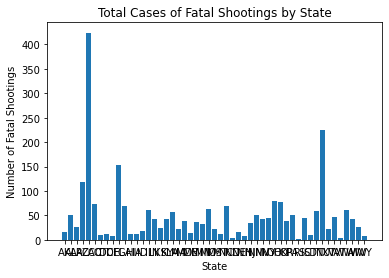

In [306]:
'''
The goal is to make a visualization of our data so we can find out which state in the set has the most fatal police shootings

Create a bar graph using the df_state_stats DataFrame to visualize the trend of fatal shootings per state
'''

plt.bar(df_state_stats.index, df_state_stats['Total Cases'])
plt.title('Total Cases of Fatal Shootings by State')
plt.xlabel('State')
plt.ylabel('Number of Fatal Shootings')
plt.show()

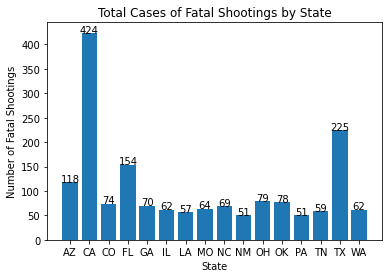

In [307]:
'''
The above bar graph is extremely packed and the majority of the values are very small, so they don't matter to us when trying to determine which states have the highest number of fatal shootings. Let's repeat the process using only the states with number of killings greater than 50. With this, we can see the data better.
'''

df_state_stats_temp = df_state_stats[df_state_stats['Total Cases'] > 50]
# df_state_stats_temp

# plt.bar(df_state_stats_temp.index, df_state_stats_temp['Total Cases'])
# plt.title('Total Cases of Fatal Shootings by State')
# plt.xlabel('State')
# plt.ylabel('Number of Fatal Shootings')
# plt.show()

x_list = list(df_state_stats_temp.index)
y_list = list(df_state_stats_temp['Total Cases'])
plt.bar(x_list, y_list)
plt.title('Total Cases of Fatal Shootings by State')
plt.xlabel('State')
plt.ylabel('Number of Fatal Shootings')
for i in range(len(x_list)):
    plt.text(x_list[i], y_list[i], y_list[i], ha='center')
plt.show()

In [308]:
'''
The graph clearly shows that CA is the state with the highest number of fatal police shootings (over 400), followed by TX with slightly over 200 fatal shootings.

We can confirm this conclusion using code by extracting the maximum value of 'Total Cases' from the DataFrame and seeing which state it is associated with. 
The line of code below accomplishes this and does indeed confirm that CA is the state with the highest number of fatal shootings (424). 
'''
s = df_state_stats.loc[df_state_stats['Total Cases'].idxmax()]
s.name, s['Total Cases']

('CA', 424)

In [309]:
df_state_stats.columns

Index(['Total Cases', 'MANNER_OF_DEATH: shot',
       'MANNER_OF_DEATH: shot and Tasered', 'GENDER: M', 'GENDER: F',
       'RACE: A', 'RACE: W', 'RACE: H', 'RACE: B', 'RACE: O', 'RACE: N',
       'SIGNS_OF_MENTAL_ILLNESS: True', 'SIGNS_OF_MENTAL_ILLNESS: False',
       'THREAT_LEVEL: attack', 'THREAT_LEVEL: other',
       'THREAT_LEVEL: undetermined', 'FLEE: Not fleeing', 'FLEE: Car',
       'FLEE: Foot', 'FLEE: Other', 'BODY_CAMERA: False', 'BODY_CAMERA: True',
       'ARMED: gun', 'ARMED: unarmed', 'ARMED: toy weapon', 'ARMED: nail gun',
       'ARMED: knife', 'ARMED: vehicle', 'ARMED: shovel', 'ARMED: hammer',
       'ARMED: hatchet', 'ARMED: undetermined', 'ARMED: sword',
       'ARMED: machete', 'ARMED: box cutter', 'ARMED: metal object',
       'ARMED: screwdriver', 'ARMED: lawn mower blade', 'ARMED: flagpole',
       'ARMED: guns and explosives', 'ARMED: cordless drill',
       'ARMED: crossbow', 'ARMED: metal pole', 'ARMED: Taser',
       'ARMED: metal pipe', 'ARMED: metal han

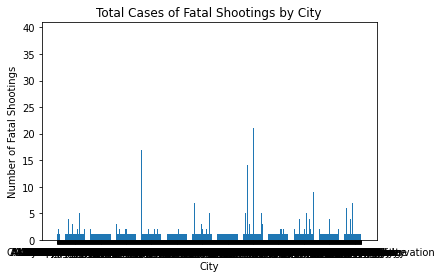

In [310]:
'''
The goal is to make a visualization of our data so we can find out which city in the set is the most dangerous. We can determine this by comparing the number of fatal shootings 

Create a bar graph using the df_city_stats DataFrame to visualize the trend of fatal shootings per city
'''

plt.bar(df_city_stats.index, df_city_stats['Total Cases'])
plt.title('Total Cases of Fatal Shootings by City')
plt.xlabel('City')
plt.ylabel('Number of Fatal Shootings')
plt.show()

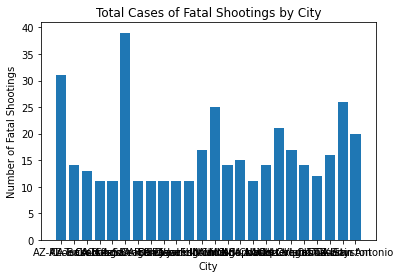

In [311]:
'''
The above bar graph is extremely packed and the majority of the values are very small, so they don't matter to us when trying to determine which cities have the highest number of fatal shootings. Let's repeat the process using only the cities with number of killings greater than 10. With this, we can see the data better.
'''

df_city_stats_temp = df_city_stats[df_city_stats['Total Cases'] > 10]
# df_city_stats_temp

plt.bar(df_city_stats_temp.index, df_city_stats_temp['Total Cases'])
plt.title('Total Cases of Fatal Shootings by City')
plt.xlabel('City')
plt.ylabel('Number of Fatal Shootings')
plt.show()

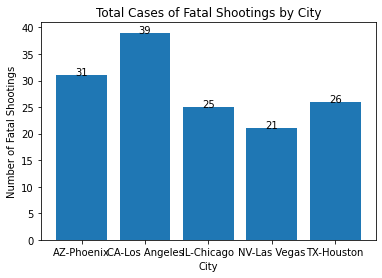

In [312]:
'''
The graph above looks a bit better, but it's still hard to distinguish the cities because of how packed the data is. We can further eliminate some data from our graph to make it easier to look at, so let's only consider those cities with number of fatal shootings above 20 and see if that works out better.
'''

df_city_stats_temp = df_city_stats[df_city_stats['Total Cases'] > 20]
# df_city_stats_temp

x_list = list(df_city_stats_temp.index)
y_list = list(df_city_stats_temp['Total Cases'])
plt.bar(x_list, y_list)
plt.title('Total Cases of Fatal Shootings by City')
plt.xlabel('City')
plt.ylabel('Number of Fatal Shootings')
for i in range(len(x_list)):
    plt.text(x_list[i], y_list[i], y_list[i], ha='center')
plt.show()

In [313]:
'''
This graph very clearly shows that Los Angeles, CA is the city with the most fatal shootings, which we can use as our basis to claim that Los Angeles is the most dangerous of the cities on this list. It is followed closely by Phoenix, AZ and Houston, TX.
'''

'\nThis graph very clearly shows that Los Angeles, CA is the city with the most fatal shootings, which we can use as our basis to claim that Los Angeles is the most dangerous of the cities on this list. It is followed closely by Phoenix, AZ and Houston, TX.\n'

In [314]:
'''
The goal is to find out what the most common way of being armed is. We can do this by iterating through every index and sum up the values in each column for method of arms

We can store the results in a dictionary
'''

armed_counts = dict()
armed_cols = [c for c in df_state_stats.columns if c[0:5] == "ARMED"]

for index, row in df_state_stats.iterrows():
    for col in armed_cols:
        arm_type = col[7:]
        armed_counts[arm_type] = armed_counts.get(arm_type, 0) + row[col]

'''
Now the armed_counts dictionary contains each way of being armed along with its corresponding number of appearances.

We can sort the dictionary by value in non-increasing order to determine what the most common ways of being armed are.

By doing this, we can see that the most common way of being armed is with a gun (1407 occurrences), followed by knife with 373 occurrences.
'''

armed_counts_list = sorted(armed_counts.items(), key=lambda x:x[1], reverse=True)
armed_counts_list

[('gun', 1407),
 ('knife', 373),
 ('vehicle', 177),
 ('unarmed', 171),
 ('undetermined', 117),
 ('toy weapon', 104),
 ('machete', 18),
 ('unknown weapon', 18),
 ('Taser', 9),
 ('ax', 9),
 ('sword', 8),
 ('baseball bat', 8),
 ('hammer', 7),
 ('box cutter', 7),
 ('metal pipe', 7),
 ('hatchet', 6),
 ('crossbow', 6),
 ('screwdriver', 5),
 ('blunt object', 5),
 ('gun and knife', 5),
 ('guns and explosives', 3),
 ('metal stick', 3),
 ('scissors', 3),
 ('rock', 3),
 ('shovel', 2),
 ('metal object', 2),
 ('metal pole', 2),
 ('sharp object', 2),
 ('meat cleaver', 2),
 ('beer bottle', 2),
 ('brick', 2),
 ('chain saw', 2),
 ('baton', 2),
 ('hatchet and gun', 2),
 ('piece of wood', 2),
 ('pipe', 2),
 ('nail gun', 1),
 ('lawn mower blade', 1),
 ('flagpole', 1),
 ('cordless drill', 1),
 ('metal hand tool', 1),
 ('carjack', 1),
 ('chain', 1),
 ("contractor's level", 1),
 ('stapler', 1),
 ('bean-bag gun', 1),
 ('baseball bat and fireplace poker', 1),
 ('straight edge razor', 1),
 ('hand torch', 1),
 (

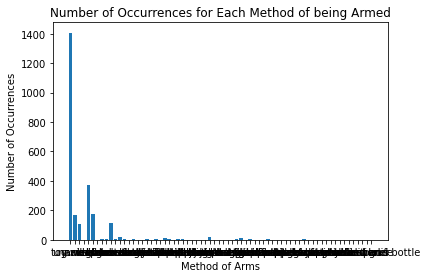

In [315]:
'''
We can also use a bar graph to visualize this data.
'''
plt.bar(armed_counts.keys(), armed_counts.values())
plt.title("Number of Occurrences for Each Method of being Armed")
plt.xlabel("Method of Arms")
plt.ylabel("Number of Occurrences")
plt.show()

In [316]:
armed_counts_reduced = dict()

for tup in armed_counts_list:
    if (tup[1] > 10):
        armed_counts_reduced[tup[0]] = tup[1]

armed_counts_reduced

{'gun': 1407,
 'knife': 373,
 'vehicle': 177,
 'unarmed': 171,
 'undetermined': 117,
 'toy weapon': 104,
 'machete': 18,
 'unknown weapon': 18}

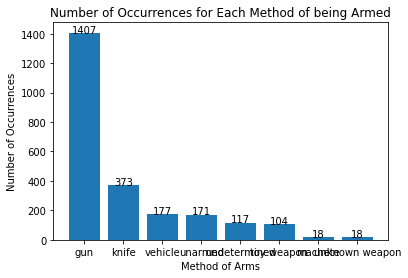

In [317]:
'''
We can also use a bar graph to visualize this data.
'''
# plt.bar(armed_counts_reduced.keys(), armed_counts_reduced.values())
# plt.title("Number of Occurrences for Each Method of being Armed")
# plt.xlabel("Method of Arms")
# plt.ylabel("Number of Occurrences")
# plt.show()


x_list = list(armed_counts_reduced.keys())
y_list = list(armed_counts_reduced.values())
plt.bar(x_list, y_list)
plt.title("Number of Occurrences for Each Method of being Armed")
plt.xlabel("Method of Arms")
plt.ylabel("Number of Occurrences")
for i in range(len(x_list)):
    plt.text(x_list[i], y_list[i], y_list[i], ha='center')
plt.show()

In [318]:
'''
The graph above clearly shows that guns are the most common by a very wide margin, followed by knives in second and then vehicles in third place.
Interestingly, we can also see here that the 4th most common occurrence is actually "unarmed" - no weapons/items 
'''

'\nThe graph above clearly shows that guns are the most common by a very wide margin, followed by knives in second and then vehicles in third place.\nInterestingly, we can also see here that the 4th most common occurrence is actually "unarmed" - no weapons/items \n'

Text(0.5, 1.0, 'Age Distribution of All Victims')

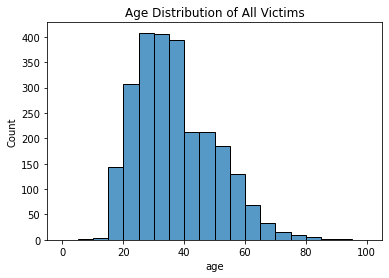

In [319]:
'''
Now let's look at the age distribution of all the victims
'''

all_hist = sb.histplot(df_total['age'], bins=20, binrange=(0,100))
all_hist.set_title("Age Distribution of All Victims")

In [320]:
# we can look at the stats summary for the ages across all races
df_total['age'].describe()

# Overall mean age: 36.56
# Overall age stdev: 12.88
# Overall min. age: 6
# Overall median age: 35
# Overall max. age: 91

count    2535.000000
mean       36.556497
std        12.878628
min         6.000000
25%        27.000000
50%        35.000000
75%        45.000000
max        91.000000
Name: age, dtype: float64

Text(0.5, 1.0, 'Age Distribution of Asian Victims')

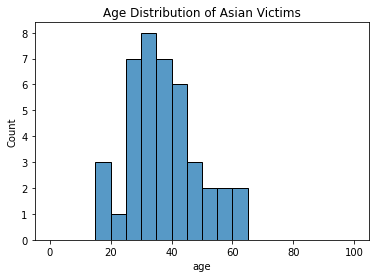

In [321]:
df_a = df_total[df_total['race'] == 'A']
a_hist = sb.histplot(df_a['age'], bins=20, binrange=(0,100))
a_hist.set_title("Age Distribution of Asian Victims")

In [322]:
# we can look at the stats summary for the ages across Asian people
df_a['age'].describe()

# Asian mean age: 36.76
# Asian age stdev: 11.55
# Asian min. age: 15
# Asian median age: 35
# Asian max. age: 61

count    41.000000
mean     36.917204
std      11.641386
min      15.000000
25%      28.000000
50%      35.000000
75%      44.000000
max      61.000000
Name: age, dtype: float64

Text(0.5, 1.0, 'Age Distribution of White Victims')

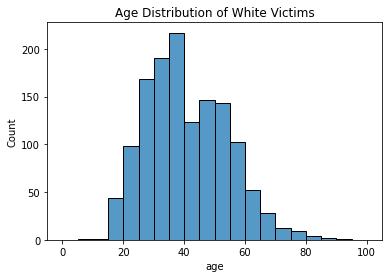

In [323]:
df_w = df_total[df_total['race'] == 'W']
w_hist = sb.histplot(df_w['age'], bins=20, binrange=(0,100))
w_hist.set_title("Age Distribution of White Victims")

In [324]:
# we can look at the stats summary for the ages across White people
df_w['age'].describe()

# White mean age: 40.27
# White age stdev: 13.39
# White min. age: 6
# White median age: 38
# White max. age: 91

count    1343.000000
mean       40.274072
std        13.380520
min         6.000000
25%        30.000000
50%        38.000000
75%        50.000000
max        91.000000
Name: age, dtype: float64

Text(0.5, 1.0, 'Age Distribution of Black Victims')

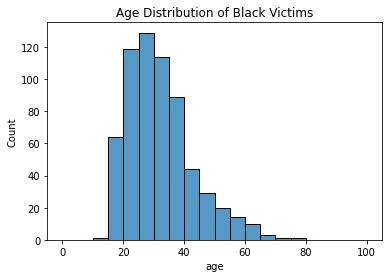

In [325]:
df_b = df_total[df_total['race'] == 'B']
b_hist = sb.histplot(df_b['age'], bins=20, binrange=(0,100))
b_hist.set_title("Age Distribution of Black Victims")

In [326]:
# we can look at the stats summary for the ages across Black people
df_b['age'].describe()

# Black mean age: 31.64
# Black age stdev: 10.84
# Black min. age: 13
# Black median age: 30
# Black max. age: 77

count    638.000000
mean      31.601453
std       10.824528
min       13.000000
25%       24.000000
50%       30.000000
75%       37.000000
max       77.000000
Name: age, dtype: float64

Text(0.5, 1.0, 'Age Distribution of Hispanic Victims')

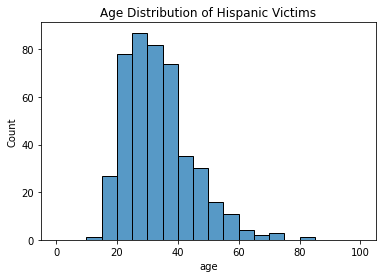

In [327]:
df_h = df_total[df_total['race'] == 'H']
a_hist = sb.histplot(df_h['age'], bins=20, binrange=(0,100))
a_hist.set_title("Age Distribution of Hispanic Victims")

In [328]:
# we can look at the stats summary for the ages across Hispanic people
df_h['age'].describe()

# Hispanic mean age: 33.07
# Hispanic age stdev: 10.83
# Hispanic min. age: 14
# Hispanic median age: 31.57
# Hispanic max. age: 80

count    451.000000
mean      33.040594
std       10.817539
min       14.000000
25%       25.000000
50%       31.540541
75%       39.000000
max       80.000000
Name: age, dtype: float64

Text(0.5, 1.0, 'Age Distribution of Native American Victims')

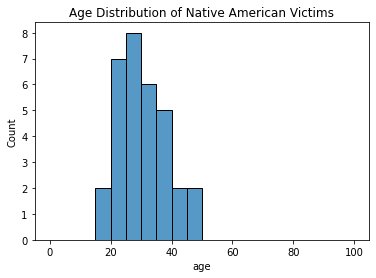

In [329]:
df_n = df_total[df_total['race'] == 'N']
a_hist = sb.histplot(df_n['age'], bins=20, binrange=(0,100))
a_hist.set_title("Age Distribution of Native American Victims")

In [330]:
# we can look at the stats summary for the ages across Native people
df_n['age'].describe()

# Native mean age: 30.38
# Native age stdev: 7.97
# Native min. age: 19
# Native median age: 29
# Native max. age: 49

count    32.000000
mean     30.375000
std       7.966664
min      19.000000
25%      24.000000
50%      29.000000
75%      35.250000
max      49.000000
Name: age, dtype: float64

Text(0.5, 1.0, 'Age Distribution of Other Race Victims')

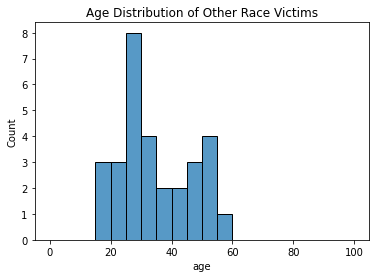

In [331]:
df_o = df_total[df_total['race'] == 'O']
a_hist = sb.histplot(df_o['age'], bins=20, binrange=(0,100))
a_hist.set_title("Age Distribution of Other Race Victims")

In [332]:
# we can look at the stats summary for the ages across Other races
df_o['age'].describe()

# Other races mean age: 33.79
# Other races age stdev: 11.61
# Other races min. age: 18
# Other races median age: 30
# Other races max. age: 56

count    30.000000
mean     34.466667
std      11.996360
min      18.000000
25%      27.000000
50%      30.000000
75%      45.000000
max      56.000000
Name: age, dtype: float64

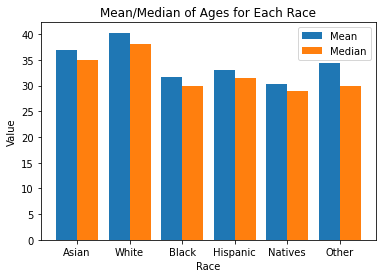

In [333]:
'''
Now let's graph the means and medians of the ages for each race and compare them
'''


races = ["Asian", "White", "Black", "Hispanic", "Natives", "Other"]
# mean_list, median_list = [], []
mean_list = [df_a['age'].mean(), df_w['age'].mean(), df_b['age'].mean(), df_h['age'].mean(), df_n['age'].mean(), df_o['age'].mean()]
median_list = [df_a['age'].median(), df_w['age'].median(), df_b['age'].median(), df_h['age'].median(), df_n['age'].median(), df_o['age'].median()]

x_axis = np.arange(len(races))

plt.bar(x_axis - 0.2, mean_list, width = 0.4, label = 'Mean')
plt.bar(x_axis + 0.2, median_list, width = 0.4, label = 'Median')

plt.title("Mean/Median of Ages for Each Race")
plt.xlabel("Race")
plt.ylabel("Value")

plt.xticks(x_axis, races)

plt.legend()

plt.show()

In [334]:
'''
The graph above shows that Native American victims had the lowest mean and median ages, while White victims had the highest mean and median ages.  
'''

'\nThe graph above shows that Native American victims had the lowest mean and median ages, while White victims had the highest mean and median ages.  \n'

In [335]:
list(set(sorted(df_total['age'].unique())))
df_total['race'].unique()

array(['A', 'W', 'H', 'B', 'O', 'N'], dtype=object)

In [336]:
'''
Let's get the total number of people killed per race.
'''

race_count = df_total.groupby('race')['race'].size()
race_count 

race
A      41
B     638
H     451
N      32
O      30
W    1343
Name: race, dtype: int64

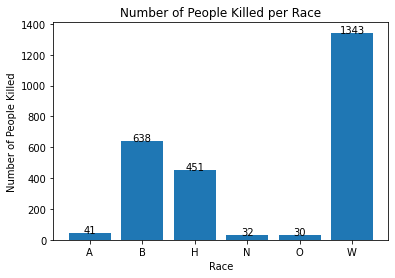

In [337]:
x_list = race_count.index.tolist()
y_list = race_count.tolist()
plt.bar(x_list, y_list)
plt.title("Number of People Killed per Race")
plt.xlabel("Race")
plt.ylabel("Number of People Killed")
for i in range(len(x_list)):
    plt.text(x_list[i], y_list[i], y_list[i], ha='center')
plt.show()

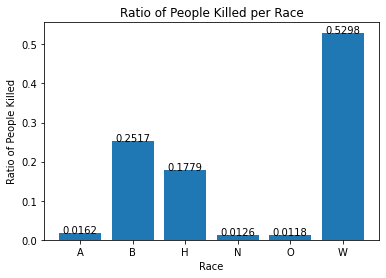

In [338]:
'''
Now we can find the ratio of deaths for each race over the total amount of deaths and visualize that data as well
'''

total_deaths = race_count.sum()
x_list = race_count.index.tolist()
y_list = [round((y / total_deaths), 4) for y in race_count.tolist()]
plt.bar(x_list, y_list)
plt.title("Ratio of People Killed per Race")
plt.xlabel("Race")
plt.ylabel("Ratio of People Killed")
for i in range(len(x_list)):
    plt.text(x_list[i], y_list[i], y_list[i], ha='center')
plt.show()

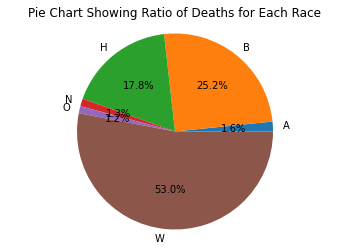

In [339]:
'''
The same proportion data can be visualized better as a pie chart. The pie chart below shows that white people make up the majority of the deaths in our dataset.  
'''

fig1, ax1 = plt.subplots()
ax1.pie(y_list, labels=x_list, autopct='%1.1f%%')
ax1.axis('equal')
plt.title('Pie Chart Showing Ratio of Deaths for Each Race')
plt.show()

In [340]:
df_temp 

,index,Geographic area,City,share_white,share_black,share_native_american,share_asian,share_hispanic,city,Median Income,poverty_rate,percent_completed_hs
0,0,AK,Adak city,19.6,4.0,5.5,52.5,8.9,AK-Adak city,78500.000000,39.3,93.4
1,1,AK,Akhiok city,8.5,1.4,50.7,1.4,11.3,AK-Akhiok city,26250.000000,40.5,62.5
2,2,AK,Akiachak CDP,3.5,0.2,95.1,0.2,0.2,AK-Akiachak CDP,38750.000000,26.1,76.7
3,3,AK,Akiak city,5.2,0.0,92.8,0.0,0.3,AK-Akiak city,42000.000000,31.3,81.3
4,4,AK,Akutan city,23.3,17.9,5.5,43.3,20.8,AK-Akutan city,24750.000000,16.1,73.0
...,...,...,...,...,...,...,...,...,...,...,...,...
29472,29472,WY,Woods Landing-Jelm CDP,95.9,0.0,0.0,2.1,0.0,WY-Woods Landing-Jelm CDP,60874.993464,18.6,100.0
29473,29473,WY,Worland city,89.9,0.3,1.3,0.6,16.6,WY-Worland city,41523.000000,15.3,85.6
29474,29474,WY,Wright town,94.5,0.1,1.4,0.2,6.2,WY-Wright town,77114.000000,5.9,89.2
29475,29475,WY,Y-O Ranch CDP,92.8,1.5,2.6,0.0,11.8,WY-Y-O Ranch CDP,60874.993464,0.0,100.0


In [341]:
"""
In order to find the impact of deaths proportionate to its respective race, we need to use the supporting dataset.
We must find the 1/race proportion that race holds in order to see the impact of a person's life proportionate to the race population.
1. Find total proportion each race holds in the united states
2. take 1/proportion
3. Multiply it by the rate of death for that race
4. Compare the impact values to see how much each death impacts one race vs another
"""
list_total_races = []
j = 0
columns_race.sort()
print(columns_race)
for i in columns_race:
    newDF = df_temp[i].astype(float)
    list_total_races.append(newDF.sum())
    print(list_total_races[j])
    j+=1
sum_all_races = sum(list_total_races)
proportional_share = [i/sum_all_races for i in list_total_races]
proportional_share = [1/i for i in proportional_share]
print(proportional_share)
del y_list[4]
print(y_list)
res_race_porportion = []
j = 0
for i in proportional_share:
    x = y_list[j]
    j+=1
    res_race_porportion.append(i*x)
res_race_porportion


['share_asian', 'share_black', 'share_hispanic', 'share_native_american', 'share_white']
45167.763625974054
199939.02234999335
272926.3445175891
84111.02885521147
2434255.740651232
[67.22493336495182, 15.186629724960747, 11.125345577639228, 36.099902014358335, 1.2473627356785766]
[0.0162, 0.2517, 0.1779, 0.0126, 0.5298]


[1.0890439205122195,
 3.8224747017726197,
 1.9791989782620187,
 0.454858765380915,
 0.6608527773625099]

In [342]:
import warnings
warnings.filterwarnings("ignore")

cities.sort()
columns_race.sort()
races = df_total['race'].tolist()
races =list(set(races))
races.remove('O')
races.sort()
df_total['Median Income'] = np.nan
df_total['poverty_rate'] = np.nan
df_total['percent_completed_hs'] = np.nan
df_total_temp = df_total.copy()
for i in cities:
    temp = df_total_temp.loc[df_total_temp['city'] == i]
    supptemp = df_support.loc[df_support['city'] == i]
    support_proportion_race = {}
    ind = 0
    for j in columns_race:
        temp2 = temp.loc[temp['race'] == races[ind]]
        support_proportion_race['Median Income'] = supptemp['Median Income'].iat[0] * supptemp[j].iat[0]/100
        support_proportion_race['poverty_rate'] = supptemp['poverty_rate'].iat[0] * supptemp[j].iat[0]/100
        support_proportion_race['percent_completed_hs'] = supptemp['percent_completed_hs'].iat[0] * supptemp[j].iat[0]/100
        #tempDF = pd.DataFrame(support_proportion_race)
        # tempDF = pd.concat([tempDF]*len(temp2), ignore_index=True)
        #print(tempDF.info())
        # print(temp2.info())
        temp2['Median Income'] = temp2['Median Income'].fillna(support_proportion_race['Median Income'])
        temp2['poverty_rate']= temp2['poverty_rate'].fillna(support_proportion_race['poverty_rate'])
        temp2['percent_completed_hs'] = temp2['percent_completed_hs'].fillna(support_proportion_race['percent_completed_hs'])
        #print(temp2.info())
        temp.loc[temp['race'] == races[ind]] = temp2
        #print(temp.info())
        ind+=1
        #print(temp.info())
    temp = temp.fillna(0)
    df_total_temp.loc[df_total_temp['city'] == i] = temp

df_total = df_total_temp
df_total

,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera,Median Income,poverty_rate,percent_completed_hs
0,3.0,Tim Elliot,02/01/15,shot,gun,53.000000,M,A,WA-Shelton,WA,True,attack,Not fleeing,False,407.79200,0.314600,0.881100
1,4.0,Lewis Lee Lembke,02/01/15,shot,gun,47.000000,M,W,OR-Aloha,OR,False,attack,Not fleeing,False,46627.38500,10.564100,62.462900
2,5.0,John Paul Quintero,03/01/15,shot and Tasered,unarmed,23.000000,M,H,KS-Wichita,KS,False,other,Not fleeing,False,7029.89100,2.646900,13.387500
3,8.0,Matthew Hoffman,04/01/15,shot,toy weapon,32.000000,M,W,CA-San Francisco,CA,True,attack,Not fleeing,False,39427.59000,6.402000,42.195000
4,9.0,Michael Rodriguez,04/01/15,shot,nail gun,39.000000,M,H,CO-Evans,CO,False,attack,Not fleeing,False,20597.92100,7.154600,32.885300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2530,2822.0,Rodney E. Jacobs,28/07/17,shot,gun,31.000000,M,B,MO-Kansas City,MO,False,attack,Not fleeing,False,13700.47900,5.681000,26.431600
2531,2813.0,TK TK,28/07/17,shot,vehicle,31.153846,M,H,NM-Albuquerque,NM,False,attack,Car,False,21963.01000,8.966400,41.563000
2532,2818.0,Dennis W. Robinson,29/07/17,shot,gun,48.000000,M,W,ID-Melba,ID,False,attack,Car,False,32470.50600,12.939600,71.325600
2533,2817.0,Isaiah Tucker,31/07/17,shot,vehicle,28.000000,M,B,WI-Oshkosh,WI,False,attack,Car,True,1322.15000,0.554900,2.768300


In [343]:
df_total_copy = df_total.copy()

# pd.get_dummies(df_total_copy, columns=['manner_of_death', 'armed', 'gender', 'city', ])
df_temp = df_total_copy.drop(columns=['id', 'name', 'date', 'state'])
# df_temp

df_temp = pd.get_dummies(df_temp, columns=['manner_of_death', 'armed', 'gender', 'city', 'signs_of_mental_illness', 'threat_level', 'flee', 'body_camera'])

training_es_x = df_temp.iloc[0:2028].drop(columns=['race'])
training_es_y = df_temp.iloc[0:2028]['race']

testing_es_x = df_temp.iloc[2028:].drop(columns=['race'])
testing_es_y = df_temp.iloc[2028:]['race']

testing_es_x

,age,Median Income,poverty_rate,percent_completed_hs,manner_of_death_shot,manner_of_death_shot and Tasered,armed_Taser,armed_air conditioner,armed_ax,armed_baseball bat,...,signs_of_mental_illness_True,threat_level_attack,threat_level_other,threat_level_undetermined,flee_Car,flee_Foot,flee_Not fleeing,flee_Other,body_camera_False,body_camera_True
2028,54.000000,12926.39400,2.530800,19.624800,1,0,0,0,0,0,...,0,1,0,0,0,0,1,0,1,0
2029,50.000000,48514.56000,14.112000,78.720000,1,0,0,0,0,0,...,1,1,0,0,0,0,1,0,0,1
2030,28.000000,7026.44700,2.200800,11.580400,1,0,0,0,0,0,...,0,0,1,0,1,0,0,0,1,0
2031,59.000000,45897.17400,5.453100,67.902300,1,0,0,0,0,0,...,1,1,0,0,0,0,1,0,0,1
2032,24.000000,25664.58000,13.284000,48.060000,1,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2530,31.000000,13700.47900,5.681000,26.431600,1,0,0,0,0,0,...,0,1,0,0,0,0,1,0,1,0
2531,31.153846,21963.01000,8.966400,41.563000,1,0,0,0,0,0,...,0,1,0,0,1,0,0,0,1,0
2532,48.000000,32470.50600,12.939600,71.325600,1,0,0,0,0,0,...,0,1,0,0,1,0,0,0,1,0
2533,28.000000,1322.15000,0.554900,2.768300,1,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,1


In [344]:
df_temp['race'].unique()

array(['A', 'W', 'H', 'B', 'O', 'N'], dtype=object)

In [358]:
model = LogisticRegression(max_iter=3000)

model.fit(training_es_x, training_es_y)
predict_train = model.predict(training_es_x)

predict_test = model.predict(testing_es_x)
predict_test

array(['W', 'W', 'B', 'W', 'W', 'B', 'B', 'W', 'W', 'W', 'B', 'W', 'H',
       'B', 'W', 'W', 'W', 'W', 'B', 'B', 'B', 'B', 'W', 'B', 'B', 'W',
       'B', 'W', 'B', 'W', 'B', 'W', 'W', 'W', 'W', 'B', 'B', 'W', 'W',
       'B', 'W', 'B', 'B', 'W', 'W', 'W', 'B', 'B', 'W', 'B', 'B', 'W',
       'B', 'B', 'B', 'W', 'W', 'W', 'H', 'W', 'W', 'B', 'W', 'B', 'W',
       'W', 'W', 'W', 'B', 'W', 'W', 'W', 'B', 'W', 'W', 'B', 'W', 'B',
       'W', 'B', 'W', 'B', 'W', 'B', 'W', 'B', 'B', 'W', 'B', 'W', 'W',
       'W', 'W', 'B', 'B', 'W', 'B', 'W', 'W', 'B', 'W', 'B', 'B', 'W',
       'W', 'W', 'W', 'B', 'B', 'W', 'W', 'B', 'W', 'W', 'B', 'B', 'B',
       'W', 'W', 'W', 'W', 'W', 'B', 'W', 'W', 'B', 'W', 'W', 'W', 'W',
       'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'B', 'W', 'B', 'W',
       'W', 'B', 'W', 'B', 'W', 'W', 'H', 'B', 'W', 'B', 'B', 'W', 'W',
       'W', 'W', 'W', 'B', 'W', 'W', 'W', 'W', 'B', 'W', 'W', 'W', 'W',
       'B', 'B', 'B', 'B', 'B', 'W', 'H', 'B', 'W', 'W', 'W', 'W

In [346]:
testing_es_x

,age,Median Income,poverty_rate,percent_completed_hs,manner_of_death_shot,manner_of_death_shot and Tasered,armed_Taser,armed_air conditioner,armed_ax,armed_baseball bat,...,signs_of_mental_illness_True,threat_level_attack,threat_level_other,threat_level_undetermined,flee_Car,flee_Foot,flee_Not fleeing,flee_Other,body_camera_False,body_camera_True
2028,54.000000,12926.39400,2.530800,19.624800,1,0,0,0,0,0,...,0,1,0,0,0,0,1,0,1,0
2029,50.000000,48514.56000,14.112000,78.720000,1,0,0,0,0,0,...,1,1,0,0,0,0,1,0,0,1
2030,28.000000,7026.44700,2.200800,11.580400,1,0,0,0,0,0,...,0,0,1,0,1,0,0,0,1,0
2031,59.000000,45897.17400,5.453100,67.902300,1,0,0,0,0,0,...,1,1,0,0,0,0,1,0,0,1
2032,24.000000,25664.58000,13.284000,48.060000,1,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2530,31.000000,13700.47900,5.681000,26.431600,1,0,0,0,0,0,...,0,1,0,0,0,0,1,0,1,0
2531,31.153846,21963.01000,8.966400,41.563000,1,0,0,0,0,0,...,0,1,0,0,1,0,0,0,1,0
2532,48.000000,32470.50600,12.939600,71.325600,1,0,0,0,0,0,...,0,1,0,0,1,0,0,0,1,0
2533,28.000000,1322.15000,0.554900,2.768300,1,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,1


In [347]:
set(predict_test)

{'B', 'H', 'O', 'W'}

In [359]:
from sklearn.metrics import accuracy_score, f1_score

# f1_score(testing_es_y, predict_test, average=None)

accuracy_test = accuracy_score(testing_es_y, predict_test)
# accuracy_test = accuracy_score(training_es_y, predict_train)
accuracy_test
# This is the accuracy of the Logistic Regression Classifier on the testing data



0.6153846153846154

In [349]:
tmodel = DecisionTreeClassifier()
# tmodel.fit(training_es_x, training_es_y)
# predict_train_tree = tmodel
tmodel.fit(training_es_x, training_es_y)
predict_tree = tmodel.predict(training_es_x)

predict_test_tree = tmodel.predict(testing_es_x)
accuracy_test_tree = accuracy_score(testing_es_y, predict_test_tree)

accuracy_test_tree
# This is the accuracy of the Decision Tree Classifier on the testing data

0.8224852071005917

[Text(0.5950465472647393, 0.9827586206896551, 'percent_completed_hs <= 51.538\ngini = 0.626\nsamples = 2028\nvalue = [33, 513, 355, 28, 29, 1070]\nclass = O'),
 Text(0.2280749539399093, 0.9482758620689655, 'poverty_rate <= 0.022\ngini = 0.702\nsamples = 1289\nvalue = [33, 481, 340, 25, 29, 381]\nclass = W'),
 Text(0.07029478458049887, 0.9137931034482759, 'Median Income <= 1.249\ngini = 0.43\nsamples = 164\nvalue = [5, 120, 7, 3, 29, 0]\nclass = W'),
 Text(0.061224489795918366, 0.8793103448275862, 'armed_toy weapon <= 0.5\ngini = 0.064\nsamples = 30\nvalue = [0, 1, 0, 0, 29, 0]\nclass = N'),
 Text(0.05668934240362812, 0.8448275862068966, 'gini = 0.0\nsamples = 29\nvalue = [0, 0, 0, 0, 29, 0]\nclass = N'),
 Text(0.06575963718820861, 0.8448275862068966, 'gini = 0.0\nsamples = 1\nvalue = [0, 1, 0, 0, 0, 0]\nclass = W'),
 Text(0.07936507936507936, 0.8793103448275862, 'city_NJ-Manchester <= 0.5\ngini = 0.207\nsamples = 134\nvalue = [5, 119, 7, 3, 0, 0]\nclass = W'),
 Text(0.07482993197278912

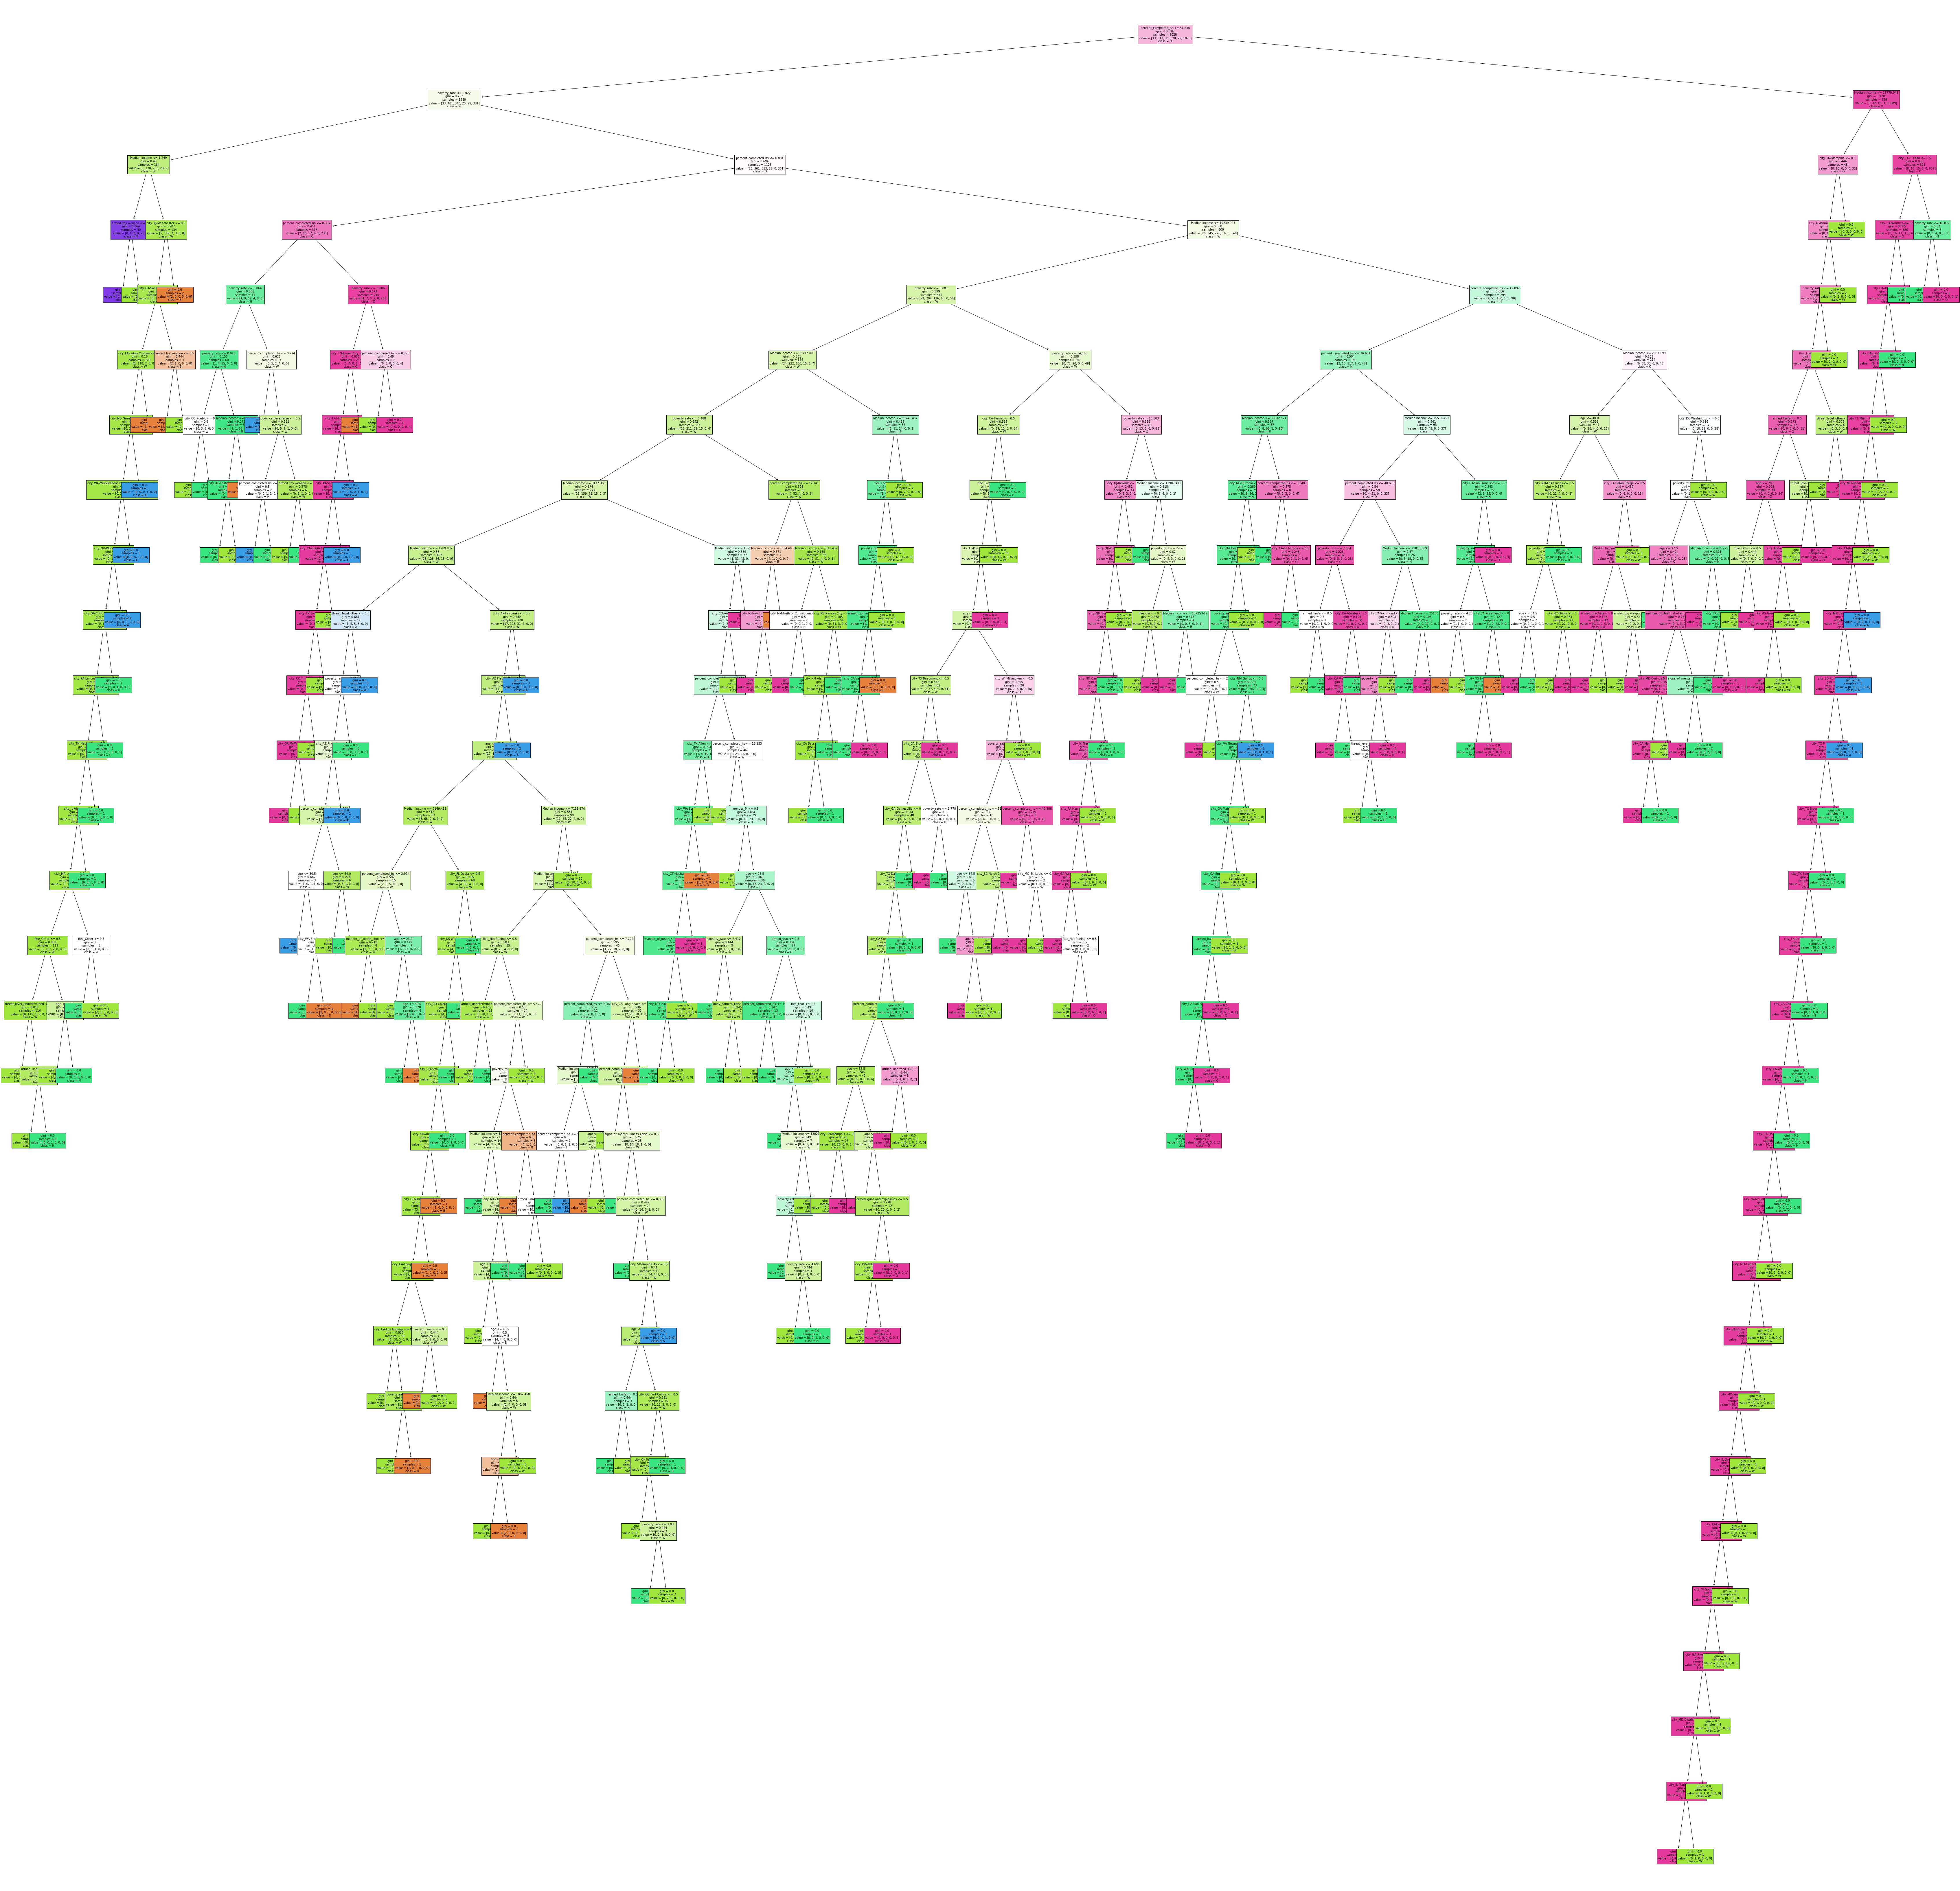

In [350]:
# sklearn.tree.plot_tree(tmodel)

plt.figure(figsize=(120,120))
sklearn.tree.plot_tree(tmodel, fontsize=10, feature_names=testing_es_x.columns, class_names=testing_es_y.unique().tolist(), filled=True)

In [351]:
from sklearn.naive_bayes import GaussianNB

bmodel = GaussianNB()

bmodel.fit(training_es_x, training_es_y)

GaussianNB()

In [352]:
predict_test_b = bmodel.predict(testing_es_x)
predict_test_b 

array(['B', 'W', 'B', 'W', 'H', 'B', 'B', 'W', 'W', 'W', 'B', 'A', 'W',
       'A', 'W', 'W', 'W', 'A', 'B', 'B', 'B', 'B', 'W', 'B', 'B', 'W',
       'W', 'W', 'B', 'W', 'B', 'W', 'A', 'B', 'A', 'A', 'B', 'A', 'A',
       'B', 'B', 'B', 'B', 'W', 'W', 'H', 'B', 'B', 'A', 'B', 'B', 'W',
       'B', 'B', 'B', 'A', 'W', 'B', 'B', 'W', 'W', 'B', 'A', 'B', 'H',
       'H', 'W', 'W', 'B', 'A', 'W', 'W', 'B', 'W', 'W', 'B', 'W', 'B',
       'W', 'B', 'W', 'B', 'B', 'A', 'B', 'B', 'B', 'W', 'B', 'W', 'W',
       'W', 'W', 'B', 'B', 'B', 'A', 'W', 'A', 'B', 'W', 'B', 'B', 'W',
       'W', 'W', 'W', 'B', 'B', 'W', 'W', 'A', 'W', 'W', 'B', 'B', 'B',
       'W', 'B', 'W', 'H', 'H', 'B', 'W', 'W', 'B', 'W', 'W', 'W', 'W',
       'W', 'W', 'W', 'W', 'W', 'H', 'W', 'W', 'W', 'B', 'A', 'B', 'H',
       'W', 'B', 'W', 'B', 'W', 'W', 'H', 'B', 'W', 'B', 'B', 'B', 'W',
       'B', 'W', 'W', 'A', 'W', 'W', 'H', 'W', 'B', 'W', 'B', 'W', 'W',
       'B', 'B', 'A', 'B', 'H', 'A', 'W', 'B', 'H', 'W', 'W', 'W

In [353]:
accuracy_test_b = accuracy_score(testing_es_y, predict_test_b)
accuracy_test_b 
# This is the accuracy of the Naive Bayes model on the testing data

0.5996055226824457

In [354]:
from sklearn.neighbors import KNeighborsClassifier

model_k = KNeighborsClassifier()

model_k.fit(training_es_x, training_es_y)
predict_train_k = model_k.predict(training_es_x)

# f1_score(training_es_y, predict_train_k, average=None)


In [355]:
predict_test_k = model_k.predict(testing_es_x)
accuracy_test_k = accuracy_score(testing_es_y, predict_test_k)
accuracy_test_k
# This is the accuracy of the K Neighbors Classifier on the testing data

0.7731755424063116

In [356]:
predict_test_k 

array(['H', 'W', 'B', 'W', 'B', 'W', 'H', 'W', 'W', 'W', 'B', 'W', 'H',
       'B', 'W', 'H', 'W', 'B', 'B', 'B', 'B', 'W', 'W', 'H', 'B', 'W',
       'B', 'W', 'B', 'B', 'B', 'B', 'W', 'B', 'B', 'B', 'B', 'B', 'B',
       'W', 'W', 'H', 'W', 'W', 'W', 'B', 'B', 'W', 'B', 'B', 'B', 'W',
       'B', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'B', 'W', 'W', 'B',
       'W', 'W', 'W', 'B', 'W', 'W', 'W', 'B', 'W', 'W', 'B', 'H', 'B',
       'W', 'W', 'W', 'B', 'B', 'B', 'W', 'B', 'A', 'W', 'H', 'W', 'W',
       'W', 'B', 'B', 'H', 'B', 'B', 'W', 'B', 'B', 'W', 'W', 'H', 'B',
       'H', 'H', 'W', 'H', 'B', 'H', 'W', 'W', 'W', 'B', 'W', 'B', 'B',
       'W', 'B', 'W', 'B', 'H', 'H', 'W', 'W', 'B', 'W', 'W', 'H', 'H',
       'W', 'W', 'W', 'W', 'W', 'B', 'W', 'W', 'W', 'N', 'H', 'B', 'H',
       'W', 'H', 'W', 'W', 'W', 'W', 'W', 'B', 'W', 'B', 'B', 'H', 'W',
       'B', 'H', 'W', 'B', 'W', 'W', 'B', 'W', 'B', 'W', 'H', 'W', 'B',
       'B', 'B', 'B', 'B', 'H', 'B', 'W', 'B', 'H', 'W', 'W', 'W